In [2]:

import importlib
import data_prep as dp
import pandas as pd
importlib.reload(dp)
print(dir(dp))  # Check if functions appear now

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [2]:
import matplotlib.pyplot as plt

In [ ]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

In [3]:
df = pd.read_csv('./../data/Sentiment Macro 5Y News.csv')

In [4]:
df.head()

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
0,0,2020-04-10,0.090039,0.090039,0.090039,1,0,0.083426,0.083426,0.083426,1,0,0.086732,0.086732,0.086732,2,0,41.169998
1,1,2020-04-19,0.081213,0.063416,0.090112,3,0,0.071839,0.065319,0.075099,3,0,0.076526,0.064368,0.082605,6,0,43.830002
2,2,2020-04-21,0.086795,0.086795,0.086795,1,0,0.089779,0.089779,0.089779,1,0,0.088287,0.088287,0.088287,2,0,45.410000
3,3,2020-04-24,0.089388,0.089388,0.089388,1,0,0.059070,0.059070,0.059070,1,0,0.074229,0.074229,0.074229,2,0,35.930000
4,4,2020-04-27,-0.521714,-0.521714,-0.521714,0,1,0.091155,0.091155,0.091155,1,0,-0.215279,-0.215279,-0.215279,1,1,33.290001


In [5]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df['mean_sentiment_decay'] = df['overall_mean'].shift(1)  # Decay from yesterday
df['shock_pos'] = df['overall_max'] #best new
df['shock_neg'] = df['overall_min'] #worst new 
df['sentiment_dominance'] = df['summary_pos_count'] - df['summary_neg_count'] # which type of new is more prevalent (p/n)?
df['dominance_trigger'] = (df['sentiment_dominance'] < -5).astype(int) #if one type of news is more prevalent than the other, it will trigger a shock



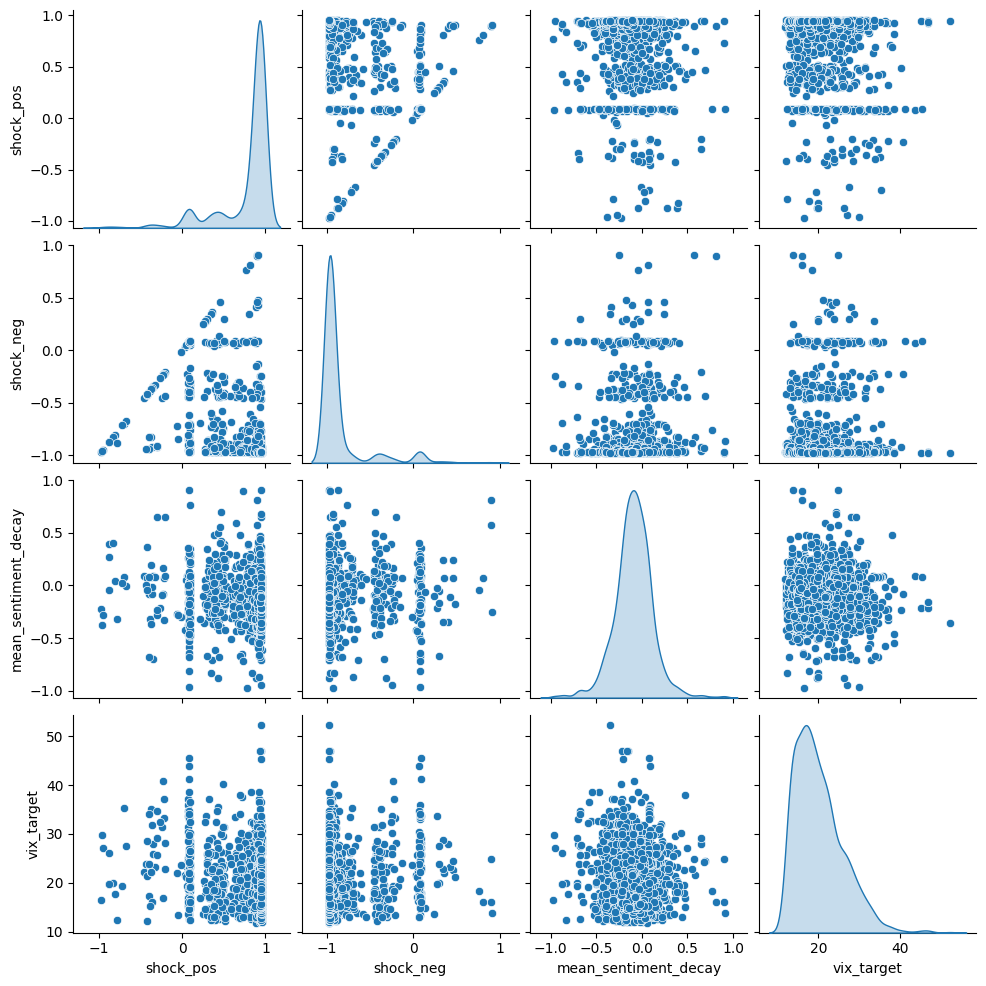

In [6]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [7]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]


In [8]:

df_model = df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']

model = MarkovRegression(y, exog=X, k_regimes=2, switching_variance=False)
results = model.fit(disp=False)
print(f"Features: {feature_sets[0]}")
print(f"AIC: {results.aic:.3f}, LogL: {results.llf:.3f}")
print(results.summary().tables[0])
print("-" * 80)


Features: ['shock_neg', 'dominance_trigger']
AIC: 9073.089, LogL: -4527.544
                        Markov Switching Model Results                        
Dep. Variable:             vix_target   No. Observations:                 1659
Model:               MarkovRegression   Log Likelihood               -4527.544
Date:                Fri, 11 Apr 2025   AIC                           9073.089
Time:                        17:21:02   BIC                           9121.814
Sample:                             0   HQIC                          9091.149
                               - 1659                                         
Covariance Type:               approx                                         
--------------------------------------------------------------------------------


In [9]:
# Get the most likely regime at each time step
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0)
selected_features = feature_sets[0]


In [10]:
df_model['vix_target_t+1'] = df_model['vix_target'].shift(-1) #lag for predicting the vix level, not the regime prediction

regime_col = df_model['regime_t'].copy() #so that it doesnt erase

df_model = df_model.dropna(subset=selected_features + ['vix_target_t+1']).copy()

df_model['regime_t'] = regime_col.loc[df_model.index]


X = df_model[selected_features]
y = df_model['vix_target_t+1']

model = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    switching_variance=False
)
results = model.fit() #model for predicting the vix level t+1


In [11]:
print(results.summary())



                        Markov Switching Model Results                        
Dep. Variable:         vix_target_t+1   No. Observations:                 1658
Model:               MarkovRegression   Log Likelihood               -4517.807
Date:                Fri, 11 Apr 2025   AIC                           9053.615
Time:                        17:21:09   BIC                           9102.335
Sample:                             0   HQIC                          9071.674
                               - 1658                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0654      0.412     41.449      0.000      16.258      17.872
x1             0.1593      0.451      0.353      0.7

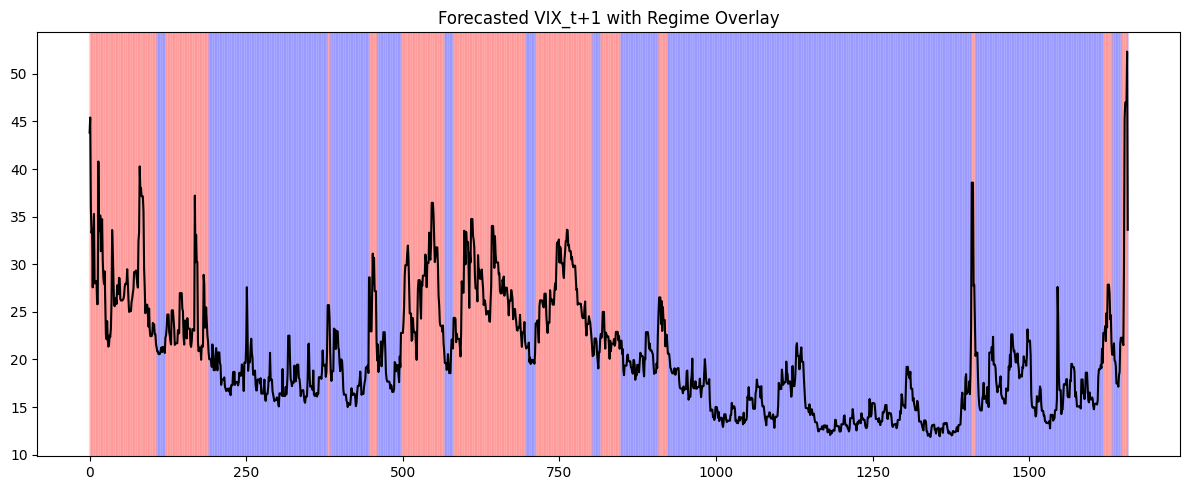

In [12]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target_t+1'], label='VIX_t+1', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i] - 0.5, df_model.index[i] + 0.5, color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [13]:
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0) #regime dataset for t


In [14]:
df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1


In [15]:
classification_df = df_model.dropna(subset=selected_features + ['regime_t+1']).copy() #classification dataset for t+1, for telling if regime is panic or not
X_cls = classification_df[selected_features]
y_cls = classification_df['regime_t+1']


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)
clf.fit(X_cls, y_cls)

# Evaluate
y_pred = clf.predict(X_cls)
print(classification_report(y_cls, y_pred))


              precision    recall  f1-score   support

         0.0       0.74      0.97      0.84      1112
         1.0       0.84      0.30      0.44       545

    accuracy                           0.75      1657
   macro avg       0.79      0.64      0.64      1657
weighted avg       0.77      0.75      0.71      1657



In [32]:
probs = clf.predict_proba(X_cls)[:, 1]
classification_df['panic_prob'] = probs


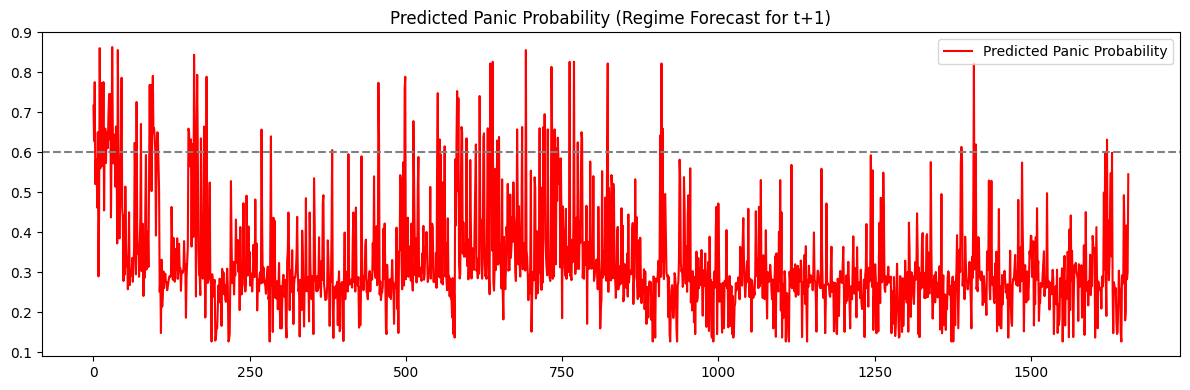

In [33]:
plt.figure(figsize=(12, 4))
plt.plot(classification_df.index, classification_df['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


In [47]:


classification_df.index = pd.to_datetime(classification_df.index)


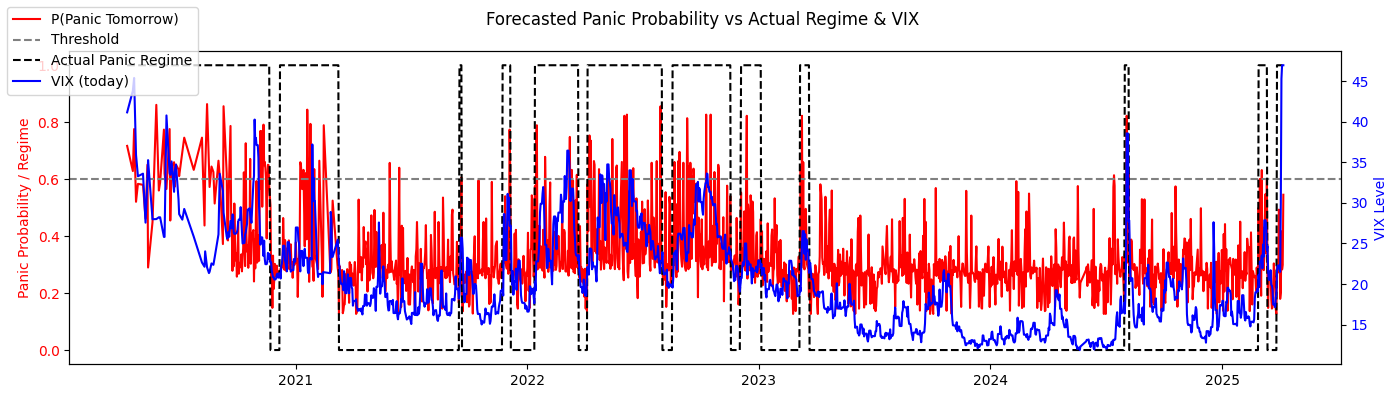

In [48]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


In [53]:
import numpy as np

# Detect spikes in panic probability
prob_spike = np.append([0], np.diff(probs)) > 0.3  # threshold adjustable

# Detect regime switches
delta_regime = np.diff(classification_df['regime_t+1'].values, prepend=classification_df['regime_t+1'].values[0])
regime_switch = delta_regime == 1   # calm → panic only


# Signal: spike + regime shift
signal = prob_spike & regime_switch
classification_df['signal'] = signal


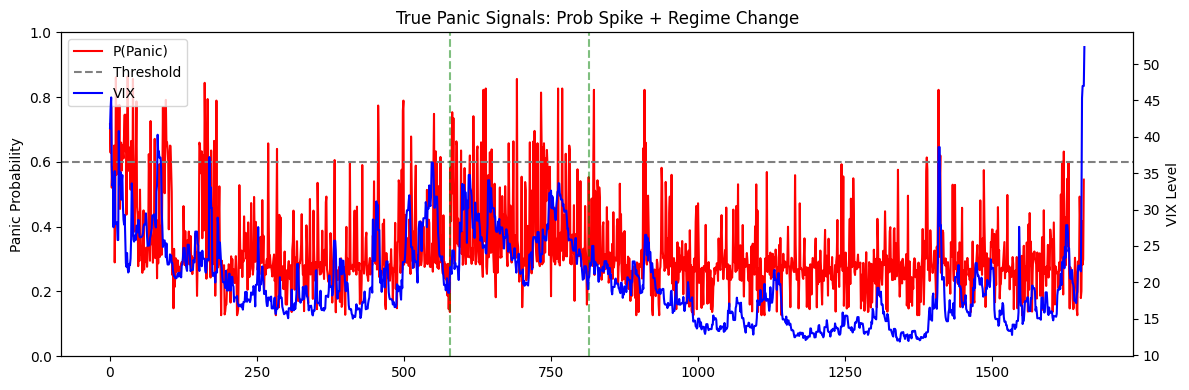

In [54]:
fig, ax1 = plt.subplots(figsize=(12, 4))

# Left Y-axis: Panic Probability
ax1.plot(probs, label='P(Panic)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.set_ylabel('Panic Probability')
ax1.set_ylim(0, 1)

# Right Y-axis: VIX
ax2 = ax1.twinx()
ax2.plot(df_model['vix_target'].values, label='VIX', color='blue')
ax2.set_ylabel('VIX Level')

# Signal lines
for i, val in enumerate(classification_df['signal']):
    if val:
        ax1.axvline(i, color='green', linestyle='--', alpha=0.5)

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('True Panic Signals: Prob Spike + Regime Change')
plt.tight_layout()
plt.show()


# New Part, forecast

In [55]:
calm_df = df_model[df_model['regime_t'] == 0]['shock_neg']
panic_df = df_model[df_model['regime_t'] == 1]['shock_neg']

In [56]:
df_model.head()

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,regime_t,vix_target_t+1,regime_t+1
0,0,2020-04-10,0.090039,0.090039,0.090039,1,0,0.083426,0.083426,0.083426,...,0,41.169998,NaN,0.086732,0.086732,1,0,1,43.830002,1.0
1,1,2020-04-19,0.081213,0.063416,0.090112,3,0,0.071839,0.065319,0.075099,...,0,43.830002,0.086732,0.082605,0.064368,3,0,1,45.410000,1.0
2,2,2020-04-21,0.086795,0.086795,0.086795,1,0,0.089779,0.089779,0.089779,...,0,45.410000,0.076526,0.088287,0.088287,1,0,1,35.930000,1.0
3,3,2020-04-24,0.089388,0.089388,0.089388,1,0,0.059070,0.059070,0.059070,...,0,35.930000,0.088287,0.074229,0.074229,1,0,1,33.290001,1.0
4,4,2020-04-27,-0.521714,-0.521714,-0.521714,0,1,0.091155,0.091155,0.091155,...,1,33.290001,0.074229,-0.215279,-0.215279,-1,0,1,33.610001,1.0


In [61]:
from statsmodels.tsa.ar_model import AutoReg #change lags when more data is available

model_calm = AutoReg(calm_df, lags=10).fit()
model_panic = AutoReg(panic_df, lags=10).fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [62]:
regime_today = df_model['regime_t'].iloc[-1]
model = model_panic if regime_today == 1 else model_calm

In [83]:
shock_forecast = []
history = [df_model['shock_neg'].dropna().iloc[-1]]  # Corrected here

for _ in range(10):
    next_val = model.predict(start=len(history), end=len(history)).iloc[0]

    shock_forecast.append(next_val)
    history.append(next_val)


In [84]:
# Given model_calm and model_panic already trained for this feature
history = [df_model['dominance_trigger'].dropna().iloc[-1]]
dom_forecast = []

for _ in range(10):
    next_val = model.predict(start=len(history), end=len(history)).iloc[0]
    dom_forecast.append(next_val)
    history.append(next_val)


In [85]:
decay_forecast = []
decay_hist = [df_model['mean_sentiment_decay'].dropna().iloc[-1]]

for _ in range(10):
    next_val = model.predict(start=len(decay_hist), end=len(decay_hist)).iloc[0]
    decay_forecast.append(next_val)
    decay_hist.append(next_val)


In [86]:
min_forecast = []
min_hist = [df_model['overall_min'].dropna().iloc[-1]]

for _ in range(10):
    next_val = model.predict(start=len(min_hist), end=len(min_hist)).iloc[0]
    min_forecast.append(next_val)
    min_hist.append(next_val)


In [87]:
domi_forecast = []
domi_hist = [df_model['sentiment_dominance'].dropna().iloc[-1]]

for _ in range(10):
    next_val = model.predict(start=len(domi_hist), end=len(domi_hist)).iloc[0]
    domi_forecast.append(next_val)
    domi_hist.append(next_val)


In [88]:
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.set_index('date')


KeyError: 'date'

In [90]:
df_forecast = pd.DataFrame({
    'shock_neg': shock_forecast,
    'dominance_trigger': dom_forecast,
    'mean_sentiment_decay': decay_forecast,
    'overall_min': min_forecast,
    'sentiment_dominance': domi_forecast
}, index=pd.date_range(start=df_model.index[-1] + pd.Timedelta(days=1), periods=10))


In [95]:
X = df_model[selected_features]
X = sm.add_constant(X)  # this adds the intercept column


In [97]:

n_features = len(selected_features) + 1  # const + features

# Grab regime-specific coefficients
regime_0_params = results.params[:n_features]
regime_1_params = results.params[n_features:2*n_features]

X_future = df_forecast[selected_features]
X_future_const = sm.add_constant(X_future, has_constant='add')  # makes sure you don’t double-add
print(X_future_const.shape)  # should be (5, n_features + 1)

# Select which regime to simulate under (e.g., current regime)
regime_params = regime_0_params if regime_today == 0 else regime_1_params
#df_forecast['vix_pred'] = X_future_const @ regime_params
print("X_future_const shape:", X_future_const.shape)
print("Regime param shape:", results.params[:X_future_const.shape[1]].shape)


#results.predict(X_future)
n_features = X_future_const.shape[1]

regime_0_params = results.params[:n_features]
regime_1_params = results.params[n_features:2*n_features]
regime_params = regime_0_params if regime_today == 0 else regime_1_params

df_forecast['vix_pred'] = X_future_const.values @ regime_params.values


(10, 3)
X_future_const shape: (10, 3)
Regime param shape: (3,)


In [98]:
df_forecast['panic_prob'] = clf.predict_proba(df_forecast[selected_features])[:, 1]
df_forecast['regime_pred'] = clf.predict(df_forecast[selected_features])



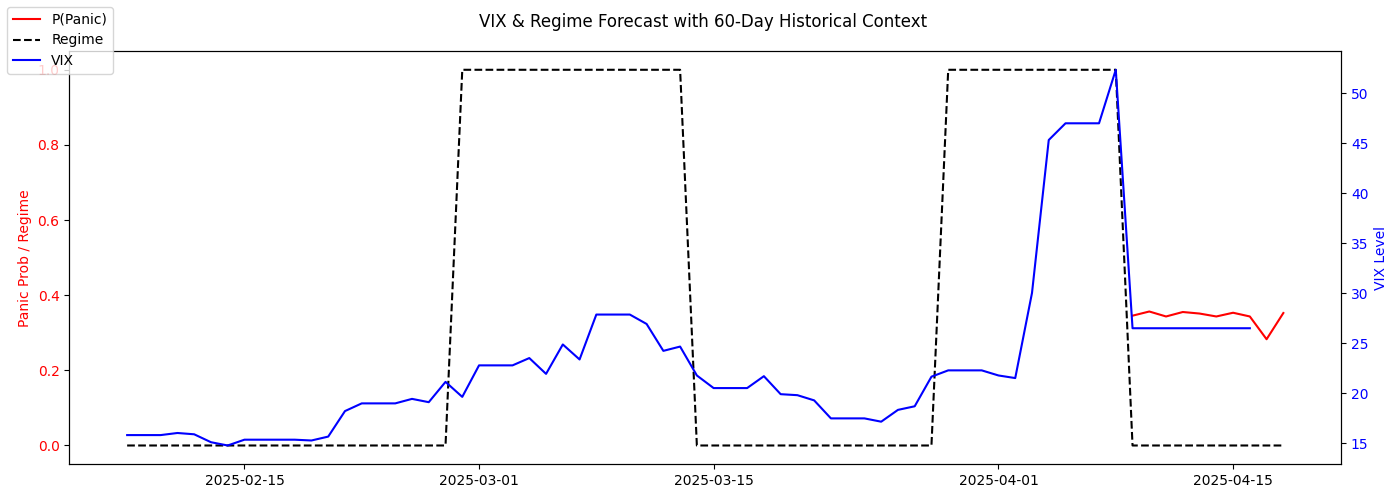

In [101]:
history = df_model[selected_features + ['vix_target', 'regime_t']].copy()
history = history.iloc[-60:].copy()

history = history.rename(columns={
    'vix_target': 'vix_pred',
    'regime_t': 'regime_pred'  # optional
})
history['panic_prob'] = np.nan  # since this wasn't calculated historically

df_full = pd.concat([history, df_forecast], axis=0)


fig, ax1 = plt.subplots(figsize=(14, 5))

# Panic Probability
ax1.plot(df_full.index, df_full['panic_prob'], label='P(Panic)', color='red')
ax1.plot(df_full.index, df_full['regime_pred'], linestyle='--', color='black', label='Regime')
ax1.set_ylabel("Panic Prob / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# VIX Forecast / Actual
ax2 = ax1.twinx()
ax2.plot(df_full.index, df_full['vix_pred'], label='VIX', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("VIX & Regime Forecast with 60-Day Historical Context")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()



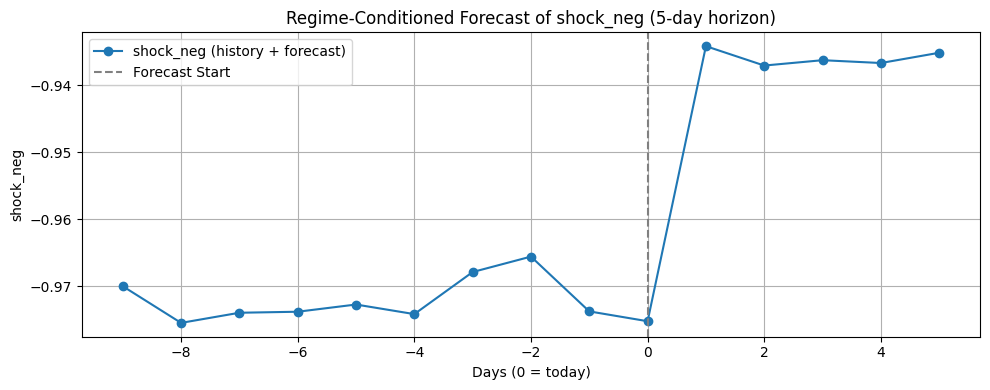

In [ ]:
import matplotlib.pyplot as plt

n_history = 10
actual = df_model['shock_neg'].dropna().iloc[-n_history:].tolist()
combined = actual + shock_forecast
x = list(range(-n_history + 1, len(shock_forecast) + 1))

plt.figure(figsize=(10, 4))
plt.plot(x, combined, marker='o', label='shock_neg (history + forecast)')
plt.axvline(0, linestyle='--', color='gray', label='Forecast Start')
plt.title('Regime-Conditioned Forecast of shock_neg (5-day horizon)')
plt.xlabel('Days (0 = today)')
plt.ylabel('shock_neg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
